# Adventure works 2022
###
Adventure Works Cycles, the fictitious company on which the AdventureWorks sample databases are based, is a large, multinational manufacturing company. The company manufactures and sells metal and composite bicycles to North American, European and Asian commercial markets. While its base operation is located in Bothell, Washington with 290 employees, several regional sales teams are located throughout their market base.


In [2]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table, inspect
import matplotlib.pyplot as plt
import seaborn as sns

engine = create_engine(f'mssql://ARINASLENOVO/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server')
con = engine.connect()

inspector = inspect(engine)
schemas = inspector.get_schema_names()

for schema in schemas:
    print(f'Schema: {schema}')

Schema: db_accessadmin
Schema: db_backupoperator
Schema: db_datareader
Schema: db_datawriter
Schema: db_ddladmin
Schema: db_denydatareader
Schema: db_denydatawriter
Schema: db_owner
Schema: db_securityadmin
Schema: dbo
Schema: guest
Schema: HumanResources
Schema: INFORMATION_SCHEMA
Schema: Person
Schema: Production
Schema: Purchasing
Schema: Sales
Schema: sys


## Database Schemas Overview

The following database schemas are of particular interest to us:

### 1. HumanResources Schema

- **Description:** Contains tables related to employees and the usage of the HumanResources department.
- **Central Table:** Employee

### 2. Person Schema

- **Description:** Contains tables with personal information for individuals in the database.
- **Central Table:** Person

### 3. Production Schema

- **Description:** Contains tables related to the manufacturing process of products.
- **Central Table:** Product

### 4. Purchasing Schema

- **Description:** Contains tables related to the purchasing process.
- **Central Table:** PurchaseOrderHeader

### 5. Sales Schema

- **Description:** Contains tables related to the sales process.
- **Central Table:** SalesOrderHeader

Let's explore a few queries from each schema:
 

## Human Resources

The Human Resources schema contains tables related to employees and is utilized by the Human Resources department. The central table is **Employee**.

#### Employee Statistics

- The company currently employs 290 individuals.
- The majority of employees are engaged in the Production Department.
- There are a total of 16 departments within the company.
- The company is actively recruiting new workers.

Number of employees:
290


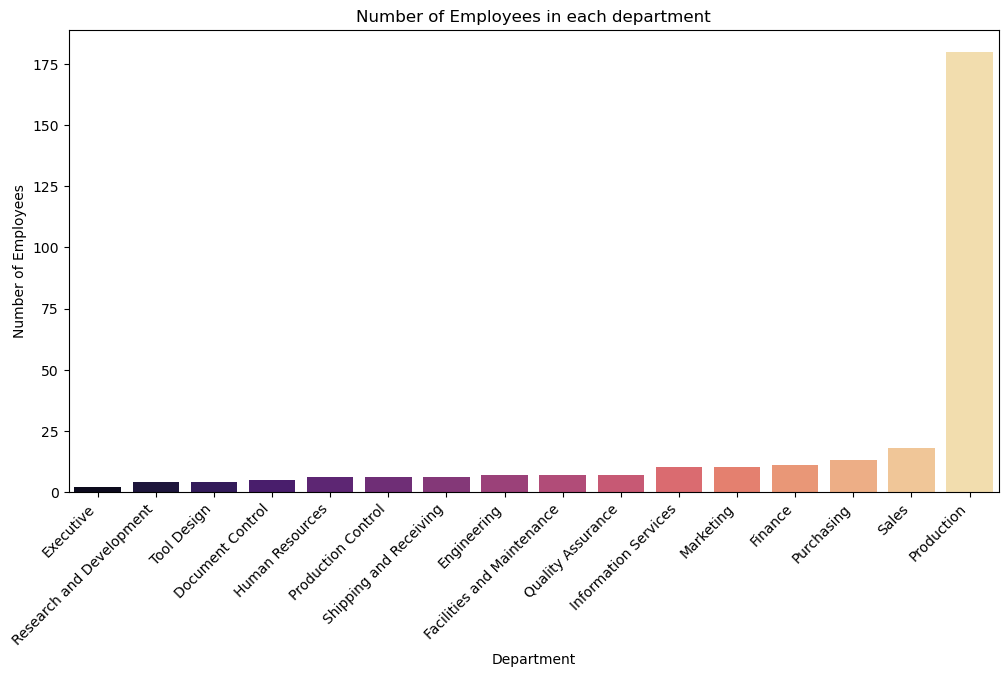

                DepartmentName  BusinessEntityID
0                    Executive                 2
1     Research and Development                 4
2                  Tool Design                 4
3             Document Control                 5
4              Human Resources                 6
5           Production Control                 6
6       Shipping and Receiving                 6
7                  Engineering                 7
8   Facilities and Maintenance                 7
9            Quality Assurance                 7
10        Information Services                10
11                   Marketing                10
12                     Finance                11
13                  Purchasing                13
14                       Sales                18
15                  Production               180


In [237]:
df = pd.read_sql("""
                    SELECT A.BusinessEntityID
                    FROM HumanResources.Employee AS A
                 """, con)

print('Number of employees:')
print(len(df))

human_resources = pd.read_sql("""
                          SELECT A.BusinessEntityID, C.[Name] AS [DepartmentName]
                          FROM HumanResources.Employee AS A
                          LEFT JOIN HumanResources.EmployeeDepartmentHistory AS B
                             ON A.BusinessEntityID = B.BusinessEntityID
                          LEFT JOIN HumanResources.Department AS C
                             ON B.DepartmentID = C.DepartmentID
                          """, con)


human_resources_grouped = human_resources.groupby('DepartmentName').agg({'BusinessEntityID':'count'}).sort_values('BusinessEntityID').reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='DepartmentName', y='BusinessEntityID', data = human_resources_grouped, palette='magma')
plt.title('Number of Employees in each department')
plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45, ha='right')
plt.show()

print(human_resources_grouped)

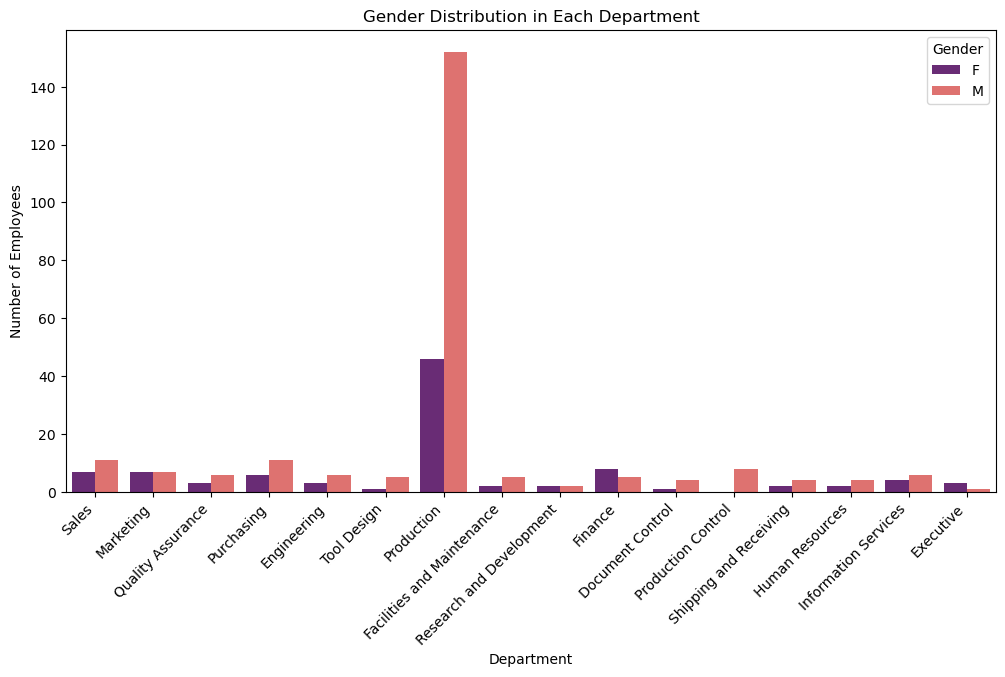

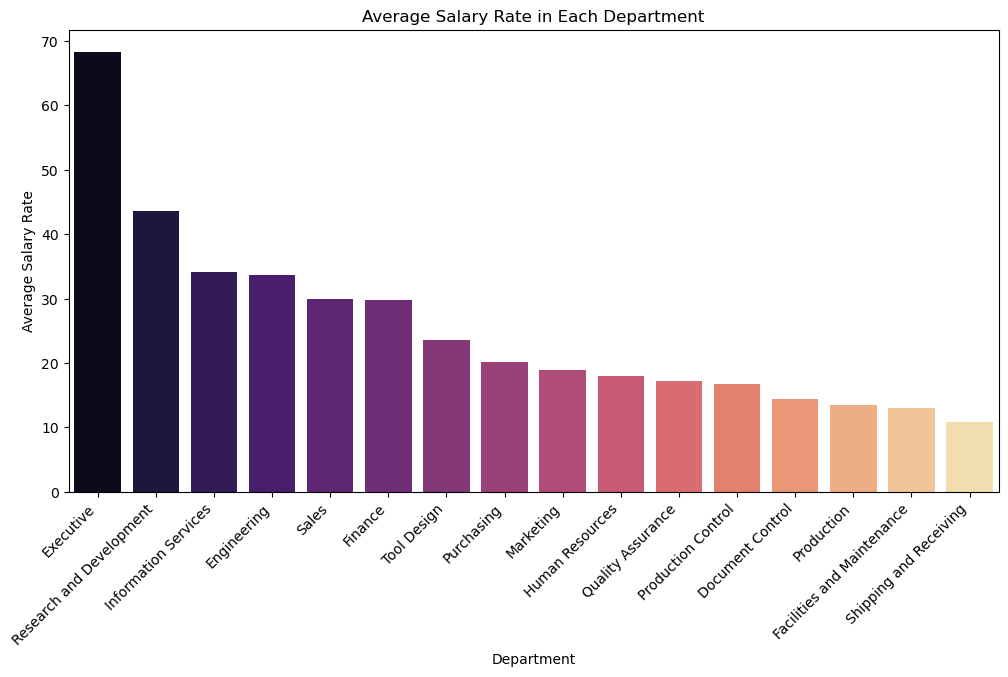

In [239]:
human_resources = pd.read_sql('SELECT A.BusinessEntityID, A.JobTitle, A.Gender, A.HireDate, D.[Name] AS [DepartmentName], C.Rate AS [SalaryRate]\
                          FROM HumanResources.Employee AS A\
                          LEFT JOIN HumanResources.EmployeeDepartmentHistory AS B\
                             ON A.BusinessEntityID = B.BusinessEntityID\
                          LEFT JOIN HumanResources.EmployeePayHistory AS C\
                             ON B.BusinessEntityID = C.BusinessEntityID\
                          LEFT JOIN HumanResources.Department AS D\
                             ON B.DepartmentID = D.DepartmentID\
                          ORDER BY A.HireDate DESC',con)

result = human_resources.groupby(by = 'DepartmentName')\
                        .agg({'BusinessEntityID':'count', 'SalaryRate':'mean'})\
                        .sort_values(by ='SalaryRate', ascending = False) 

plt.figure(figsize=(12, 6))
sns.countplot(x='DepartmentName', hue='Gender', data = human_resources, palette='magma')
plt.title('Gender Distribution in Each Department')
plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45, ha='right')  
plt.legend(title='Gender', loc='upper right')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=result.index, y='SalaryRate', data=result, palette='magma')
plt.title('Average Salary Rate in Each Department')
plt.xlabel('Department')
plt.ylabel('Average Salary Rate')
plt.xticks(rotation=45, ha='right')  
plt.show()


## Person

The Person schema contains tables of personal information for individuals in the database. The central table is **Person**.

---

### Customer Demographics

- The largest group in the Person schema is Individual Customers.
- The majority of Individual Customers reside in the USA, but AdventureWorks has customers in Canada, Germany, France, the United Kingdom, and Australia.

### Additional Information

- This schema includes contact information and addresses for each person in the database.

Goups of people in this schema:

PersonType
Individual customer    18508
Store Contact            753
General contact          289
Employee                 273
Vendor contact           156
Sales person              17
dtype: int64


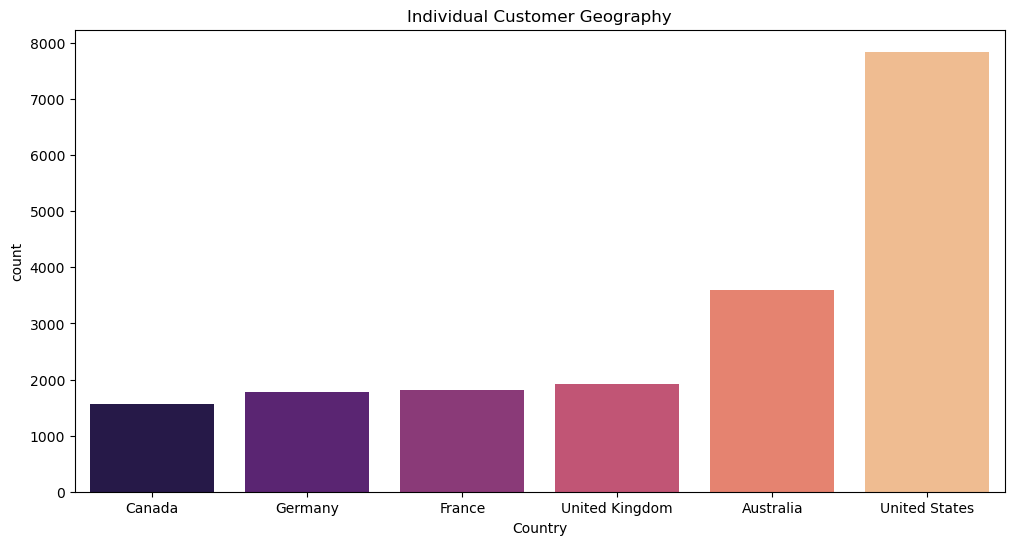

In [216]:
person = pd.read_sql("""
                  SELECT A.BusinessEntityID, A.FirstName, A.LastName, A.PersonType, A.EmailPromotion, E.[Name] AS Country
                  FROM Person.Person AS A
                  LEFT JOIN Person.BusinessEntityAddress AS B
                   ON A.BusinessEntityID = B.BusinessEntityID
                  LEFT JOIN Person.Address AS C
                   ON B.AddressID = C.AddressID
                  LEFT JOIN Person.StateProvince AS D 
                   ON C.StateProvinceID = D.StateProvinceID
                  LEFT JOIN Person.CountryRegion AS E
                   ON D.CountryRegionCode = E.CountryRegionCode
                   """, con)

# Filling missing data for Country with 'Unknown'
if person['Country'].isna().sum() > 0:
    person['Country'] = person['Country'].fillna('Unknown')
    person['Country'] = person['Country'].astype(str)

dict_person_type = {'SC':'Store Contact', 'IN':'Individual customer', 'SP':'Sales person', 'EM':'Employee',
                    'VC':'Vendor contact', 'GC':'General contact'}
person['PersonType'] = person['PersonType'].map(dict_person_type)

print('Goups of people in this schema:\n')
print(person.value_counts('PersonType'))

ind_customers = person[person['PersonType'] == 'Individual customer']

plt.figure(figsize=(12, 6))
sns.countplot(x='Country', data=ind_customers, order=ind_customers['Country'].value_counts(ascending=True).index, palette = 'magma')
plt.title('Individual Customer Geography')
plt.xlabel('Country')
plt.show()

## Sales

The Sales schema contains tables related to the sales process. The central table is **SalesOrderHeader**.

---

### Sales Overview

- AdventureWorks sells bikes, sportswear, and accessories mostly online to customers worldwide.
- The company also has physical stores where they have representatives.

### Sales Statistics

- The average order amount is $3,916.00.
- The best sales year was 2012.
- The worst sales year was 2011.

### Note

- The data is represented for the period from May 31, 2011, to June 30, 2014.
- It's important to consider that the year 2011 is not fully represented in the data.







In [217]:
sales = pd.read_sql("""
                SELECT A.SalesOrderID, A.OrderDate, A.[Status], A.CustomerID, A.OnlineOrderFlag,
                       A.TotalDue, B.[Name] AS SalesTerritoryName
                FROM Sales.SalesOrderHeader AS A
                LEFT JOIN Sales.SalesTerritory AS B
                  ON A.TerritoryID = B.TerritoryID;
                  """, con)
print(sales.value_counts('OnlineOrderFlag', normalize=True))

print('\nMost of our sales happens Online')


OnlineOrderFlag
True     0.87904
False    0.12096
dtype: float64

Most of our sales happens Online


In [6]:
sales_dates = pd.read_sql(""" 
                             SELECT MIN(OrderDate),
                             MAX(OrderDate)
                             FROM Sales.SalesOrderHeader
                         """, con)
print(sales_dates)

                       
0 2011-05-31 2014-06-30


In [218]:
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])
sales['Year'] = sales['OrderDate'].dt.year.astype(int)

sales_per_year = sales.groupby('Year')['TotalDue'].sum().reset_index()

average_order_amount = sales['TotalDue'].mean()

best_year_value = sales_per_year['TotalDue'].max()
worst_year_value = sales_per_year['TotalDue'].min()

best_year = sales_per_year[sales_per_year['TotalDue'] == best_year_value]
worst_year = sales_per_year[sales_per_year['TotalDue'] == worst_year_value]

print(f"Average Order Amount: {average_order_amount:.2f}")
print("\nSales per Year:")
print(sales_per_year)

print("\nBest Sales Year:")
print(best_year)

print("\nWorst Sales Year:")
print(worst_year)

Average Order Amount: 3916.00

Sales per Year:
   Year      TotalDue
0  2011  1.415570e+07
1  2012  3.767570e+07
2  2013  4.896589e+07
3  2014  2.241950e+07

Best Sales Year:
   Year      TotalDue
2  2013  4.896589e+07

Worst Sales Year:
   Year      TotalDue
0  2011  1.415570e+07


## Production

The Production schema contains tables related to the manufacturing process of products. The central table is **Product**.

---

### Production Overview

- AdventureWorks is involved in the production and sale of accessories, clothing, bikes, and components.
- Other products that are not categorized are used in the production process.

### Supply Chain

- In order to produce their goods, AdventureWorks purchases materials and some components from vendors.

ProductID              0
FinishedGoodsFlag      0
Prod_Cat_Name        209
dtype: int64
ProductID            0
FinishedGoodsFlag    0
Prod_Cat_Name        0
dtype: int64


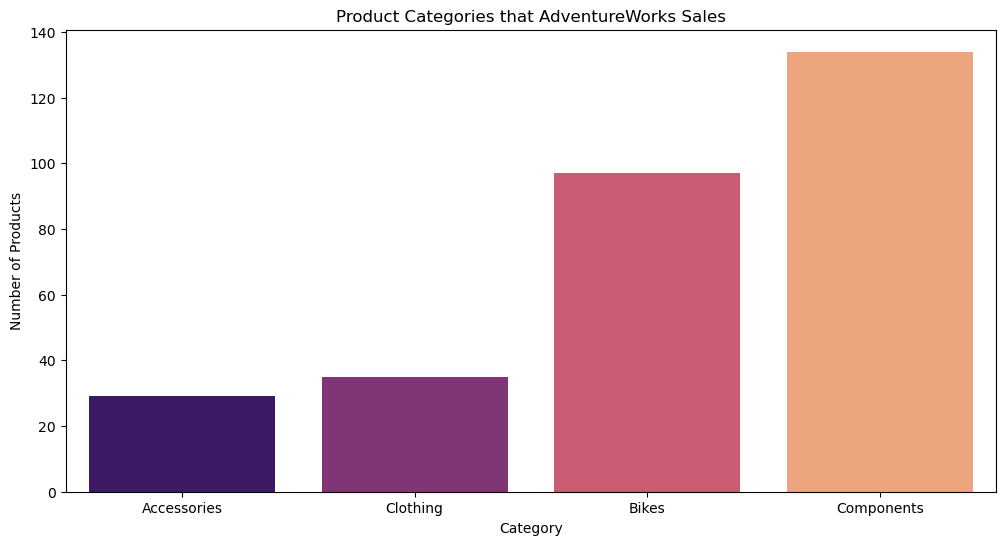

In [220]:
product = pd.read_sql("""
                    SELECT A.ProductID, A.FinishedGoodsFlag, C.[Name] AS Prod_Cat_Name
                    FROM Production.Product AS A
                    LEFT JOIN Production.ProductSubcategory AS B
                        ON A.ProductSubcategoryID = B.ProductSubcategoryID
                    LEFT JOIN Production.ProductCategory AS C
                        ON B.ProductCategoryID = C.ProductCategoryID;
                        """, con)

print(product.isna().sum())
prod_fin = product[product['FinishedGoodsFlag'] == 1]
print(prod_fin.isna().sum()) # No missing data in Finished Products

#We see that missing values are only for materials that are used in production
#so we drop them and look at salable categories
product.dropna(inplace=True)
product = product.groupby('Prod_Cat_Name').agg({'ProductID':'count'}).reset_index()
product = product.sort_values('ProductID')

plt.figure(figsize=(12, 6))
sns.barplot(x='Prod_Cat_Name', y='ProductID', data=product, palette='magma')
plt.title('Product Categories that AdventureWorks Sales')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.show()

# Purchasing

The Purchasing schema contains tables related to the purchasing process. The central table is **PurchaseOrderHeader**.

---

## Purchasing Overview

- The purchasing department is responsible for buying raw materials and parts used in the manufacture of Adventure Works Cycles bicycles.
- Adventure Works also purchases products for resale, such as bicycle apparel and bicycle add-ons like water bottles and pumps.

### Vendor Information

- AdventureWorks has 104 vendors, all located in the US.

In [241]:
vendors = pd.read_sql(""" 
                         SELECT COUNT(A.BusinessEntityID) AS Nmb_of_vendors,
                                D.CountryRegionCode
                         FROM Purchasing.Vendor AS A
                         JOIN Person.BusinessEntityAddress AS B 
                              ON A.BusinessEntityID = B.BusinessEntityID
                         JOIN Person.Address AS C 
                              ON C.AddressID = B.AddressID
                         JOIN Person.StateProvince AS D 
                              ON D.StateProvinceID = C.StateProvinceID
                         JOIN Person.CountryRegion AS E 
                              ON E.CountryRegionCode = D.CountryRegionCode
                         GROUP BY D.CountryRegionCode
                         ORDER BY Nmb_of_vendors DESC; 
                         """,con)
print(vendors)

purchasing = pd.read_sql('''
                         SELECT TOP 10 
                               B.BusinessEntityID,
                               B.[NAME] AS VendorName,
                               COUNT(A.PurchaseOrderID) AS Nbr_of_Orders,
                               SUM(A.TotalDue)/1000000 AS Total_Purchase_Amount_mil
                         FROM Purchasing.PurchaseOrderHeader AS A
                         LEFT JOIN Purchasing.Vendor AS B 
                              ON A.VendorID = B.BusinessEntityID
                         WHERE A.OrderDate BETWEEN '2014-01-01' AND '2014-12-31'
                         GROUP BY B.Name, B.BusinessEntityID
                         ORDER BY SUM(A.TotalDue) DESC
                         ''', con)

print("\n\nVendors with the highest total purchase amount:\n")
print(purchasing)

   Nmb_of_vendors CountryRegionCode
0             104                US


Vendors with the highest total purchase amount:

   BusinessEntityID                         VendorName  Nbr_of_Orders  \
0              1576                  Superior Bicycles             31   
1              1684  Professional Athletic Consultants             31   
2              1696               Chicago City Saddles             30   
3              1680                  Jackson Authority             31   
4              1632                      Sport Fan Co.             31   
5              1578                Vision Cycles, Inc.             30   
6              1678                    Proseware, Inc.             30   
7              1506         Greenwood Athletic Company             31   
8              1658                      Crowley Sport             31   
9              1586                    Mitchell Sports             31   

   Total_Purchase_Amount_mil  
0                     3.1212  
1          

# Sales Product Analysis

In [52]:
products_sales = pd.read_sql("""
                                 WITH CTE_Product AS (
                                        SELECT A.ProductID,
                                               A.[Name] AS ProductName,
	                                           A.MakeFlag,
                                               A.ProductModelID,
	                                           B.[Name] AS SubCategoryName,
	                                           C.[Name] AS CategoryName
                                        FROM Production.Product AS A
                                        LEFT JOIN Production.ProductSubcategory AS B
                                             ON A.ProductSubcategoryID = B.ProductSubcategoryID
                                        LEFT JOIN Production.ProductCategory AS C 
                                             ON B.ProductCategoryID = C.ProductCategoryID
	                                                 )
                                SELECT A.SalesOrderID,
                                       A.CustomerID,
                                       A.OrderDate,
	                                   A.OnlineOrderFlag, 
	                                   A.TerritoryID,
	                                   B.ProductID, 
	                                   B.LineTotal,
                                       B.OrderQty,
	                                   C.ProductName,
	                                   C.SubCategoryName,
	                                   C.CategoryName,
	                                   C.MakeFlag,
                                       C.ProductModelID
                                FROM Sales.SalesOrderHeader AS A
                                LEFT JOIN Sales.SalesOrderDetail AS B
                                      ON A.SalesOrderID = B.SalesOrderID
                                LEFT JOIN CTE_Product AS C
                                      ON B.ProductID = C.ProductID;
                                      """, con)

products_sales['OnlineOrderFlag'] = products_sales['OnlineOrderFlag'].map({True:'Online', False:'Offline'})
print(products_sales.head())
print(products_sales.shape)

   SalesOrderID  CustomerID  OrderDate OnlineOrderFlag  TerritoryID  \
0         43659       29825 2011-05-31         Offline            5   
1         43659       29825 2011-05-31         Offline            5   
2         43659       29825 2011-05-31         Offline            5   
3         43659       29825 2011-05-31         Offline            5   
4         43659       29825 2011-05-31         Offline            5   

   ProductID  LineTotal  OrderQty              ProductName SubCategoryName  \
0        776   2024.994         1   Mountain-100 Black, 42  Mountain Bikes   
1        777   6074.982         3   Mountain-100 Black, 44  Mountain Bikes   
2        778   2024.994         1   Mountain-100 Black, 48  Mountain Bikes   
3        771   2039.994         1  Mountain-100 Silver, 38  Mountain Bikes   
4        772   2039.994         1  Mountain-100 Silver, 42  Mountain Bikes   

  CategoryName  MakeFlag  ProductModelID  
0        Bikes      True              19  
1        Bikes    

In [53]:
print(products_sales.isna().sum())

SalesOrderID       0
CustomerID         0
OrderDate          0
OnlineOrderFlag    0
TerritoryID        0
ProductID          0
LineTotal          0
OrderQty           0
ProductName        0
SubCategoryName    0
CategoryName       0
MakeFlag           0
ProductModelID     0
dtype: int64


In [255]:
print(products_sales.groupby('SubCategoryName').agg({'OrderQty':'sum'}).sort_values('OrderQty',ascending=False))
print()
print(products_sales.groupby('CategoryName').agg({'OrderQty':'sum'}).sort_values('OrderQty', ascending=False))

                   OrderQty
SubCategoryName            
Road Bikes            47196
Mountain Bikes        28321
Jerseys               22711
Helmets               19541
Tires and Tubes       18006
Touring Bikes         14751
Gloves                13012
Road Frames           11753
Mountain Frames       11621
Bottles and Cages     10552
Shorts                 9967
Caps                   8311
Vests                  6738
Wheels                 5273
Socks                  5217
Tights                 4589
Handlebars             3950
Pedals                 3931
Touring Frames         3725
Cleaners               3319
Bike Racks             3166
Bib-Shorts             3125
Hydration Packs        2761
Saddles                2145
Fenders                2121
Derailleurs            1166
Pumps                  1130
Cranksets              1107
Locks                  1087
Brakes                 1035
Headsets               1009
Bottom Brackets         921
Chains                  774
Forks               

In [221]:
products = products_sales.groupby(['ProductID', 'ProductName', 'SubCategoryName', 'CategoryName']).agg({'LineTotal':'sum', 'OrderQty':'sum'}).reset_index()
products = products.sort_values('LineTotal', ascending=False)

### Top Performing products
Bikes is the best performing Category and Mountain Bikes are the best performing Category in TotalSales.
Our most sold products on other hand are in categories Clothing and Accessories. The most contributing to Total Sales product is a Bike: Mounain-200Black, 38 and the most sold product is AWS Logo Cap.


In [222]:
top_products = products.head(10)
print(top_products)

    ProductID              ProductName SubCategoryName CategoryName  \
65        782   Mountain-200 Black, 38  Mountain Bikes        Bikes   
66        783   Mountain-200 Black, 42  Mountain Bikes        Bikes   
62        779  Mountain-200 Silver, 38  Mountain Bikes        Bikes   
63        780  Mountain-200 Silver, 42  Mountain Bikes        Bikes   
64        781  Mountain-200 Silver, 46  Mountain Bikes        Bikes   
67        784   Mountain-200 Black, 46  Mountain Bikes        Bikes   
76        793       Road-250 Black, 44      Road Bikes        Bikes   
77        794       Road-250 Black, 48      Road Bikes        Bikes   
78        795       Road-250 Black, 52      Road Bikes        Bikes   
36        753         Road-150 Red, 56      Road Bikes        Bikes   

       LineTotal  OrderQty  
65  4.400593e+06      2977  
66  4.009495e+06      2664  
62  3.693678e+06      2394  
63  3.438479e+06      2234  
64  3.434257e+06      2216  
67  3.309673e+06      2111  
76  2.516857e+0

In [224]:
products = products.sort_values('OrderQty', ascending=False)
top_products = products.head(10)
print(top_products)

     ProductID                      ProductName    SubCategoryName  \
5          712                     AWC Logo Cap               Caps   
139        870            Water Bottle - 30 oz.  Bottles and Cages   
4          711           Sport-100 Helmet, Blue            Helmets   
8          715       Long-Sleeve Logo Jersey, L            Jerseys   
1          708          Sport-100 Helmet, Black            Helmets   
0          707            Sport-100 Helmet, Red            Helmets   
133        864                  Classic Vest, S              Vests   
142        873              Patch Kit/8 Patches    Tires and Tubes   
153        884  Short-Sleeve Classic Jersey, XL            Jerseys   
7          714       Long-Sleeve Logo Jersey, M            Jerseys   

    CategoryName      LineTotal  OrderQty  
5       Clothing   51229.445623      8311  
139  Accessories   28654.163327      6815  
4    Accessories  165406.617049      6743  
8       Clothing  198754.975360      6592  
1    Acce

## Low Performing Products
Low Performing products are mostly in category Components, most of them are seats and frames.
Least sold products are of category Components and SubCategory Touring Frames and Mountain Frames. 
* The least contributing product is a Saddle : LL Road Seaat/Saddle 
* The least sold product is a Frame: LL Touring Frame - Blue, 58. It ca depend on the odd size


In [225]:
low_products_prc = products.sort_values('LineTotal', ascending=True).head(10)
print(low_products_prc)

     ProductID                       ProductName  SubCategoryName  \
179        911               LL Road Seat/Saddle          Saddles   
3          710            Mountain Bike Socks, L            Socks   
166        897       LL Touring Frame - Blue, 58   Touring Frames   
210        943     LL Mountain Frame - Black, 40  Mountain Frames   
181        914            LL Touring Seat/Saddle          Saddles   
209        942  ML Mountain Frame-W - Silver, 38  Mountain Frames   
213        946             LL Touring Handlebars       Handlebars   
87         805                        LL Headset         Headsets   
182        915            ML Touring Seat/Saddle          Saddles   
194        927     LL Mountain Frame - Black, 52  Mountain Frames   

    CategoryName  LineTotal  OrderQty  
179   Components    162.720        10  
3       Clothing    513.000        90  
166   Components    800.208         4  
210   Components   1198.992         8  
181   Components   1480.752        91  


In [226]:
low_products_qty = products.sort_values('OrderQty', ascending=True)
print(low_products_qty.head(10))

     ProductID                       ProductName  SubCategoryName  \
166        897       LL Touring Frame - Blue, 58   Touring Frames   
209        942  ML Mountain Frame-W - Silver, 38  Mountain Frames   
210        943     LL Mountain Frame - Black, 40  Mountain Frames   
179        911               LL Road Seat/Saddle          Saddles   
194        927     LL Mountain Frame - Black, 52  Mountain Frames   
167        898       LL Touring Frame - Blue, 62   Touring Frames   
28         744     HL Mountain Frame - Black, 44  Mountain Frames   
171        903       LL Touring Frame - Blue, 44   Touring Frames   
170        902     LL Touring Frame - Yellow, 58   Touring Frames   
186        919    LL Mountain Frame - Silver, 48  Mountain Frames   

    CategoryName  LineTotal  OrderQty  
166   Components    800.208         4  
209   Components   1529.178         7  
210   Components   1198.992         8  
179   Components    162.720        10  
194   Components   2248.110        15  


## Category and SubCategory Analysis

* Bikes Category:

"Road Bikes" and "Mountain Bikes" contribute significantly to the total sales in the Bikes category.
"Mountain Bikes" have a higher average sale per item compared to "Road Bikes."


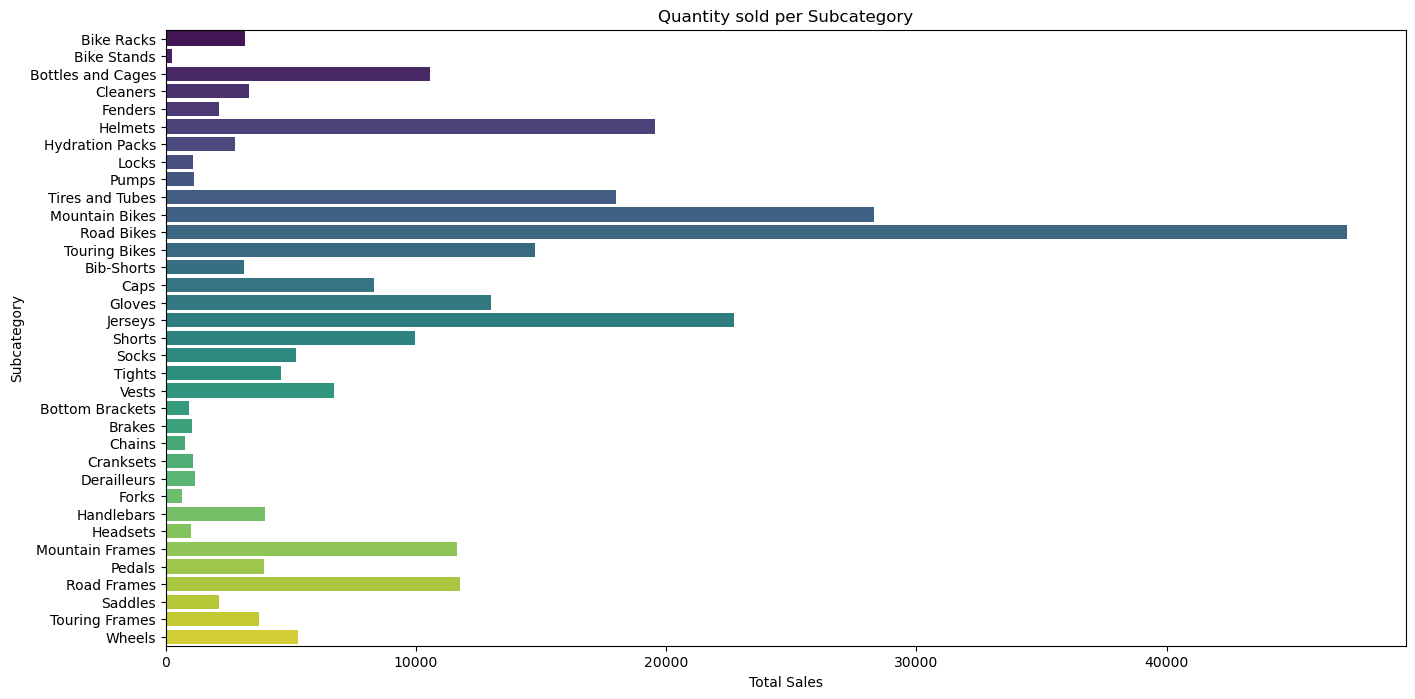

   CategoryName    SubCategoryName     LineTotal  OrderQty
0   Accessories         Bike Racks  2.370962e+05      3166
1   Accessories        Bike Stands  3.959100e+04       249
2   Accessories  Bottles and Cages  6.427479e+04     10552
3   Accessories           Cleaners  1.840697e+04      3319
4   Accessories            Fenders  4.661958e+04      2121
5   Accessories            Helmets  4.840485e+05     19541
6   Accessories    Hydration Packs  1.058264e+05      2761
7   Accessories              Locks  1.624022e+04      1087
8   Accessories              Pumps  1.351469e+04      1130
9   Accessories    Tires and Tubes  2.464545e+05     18006
10        Bikes     Mountain Bikes  3.644544e+07     28321
11        Bikes         Road Bikes  4.390944e+07     47196
12        Bikes      Touring Bikes  1.429629e+07     14751
13     Clothing         Bib-Shorts  1.675586e+05      3125
14     Clothing               Caps  5.122945e+04      8311
15     Clothing             Gloves  2.435120e+05     130

In [257]:
subcategory_analysis = products_sales.groupby(['CategoryName', 'SubCategoryName']).agg({'LineTotal': 'sum', 'OrderQty':'sum'}).reset_index()

plt.figure(figsize=(16, 8))
sns.barplot(x='OrderQty', y='SubCategoryName', data=subcategory_analysis, palette='viridis')
plt.title('Quantity sold per Subcategory')
plt.xlabel('Total Sales')
plt.ylabel('Subcategory')
plt.show()

print(subcategory_analysis)

Not a surprise that Bikes is the most contributing category of products.

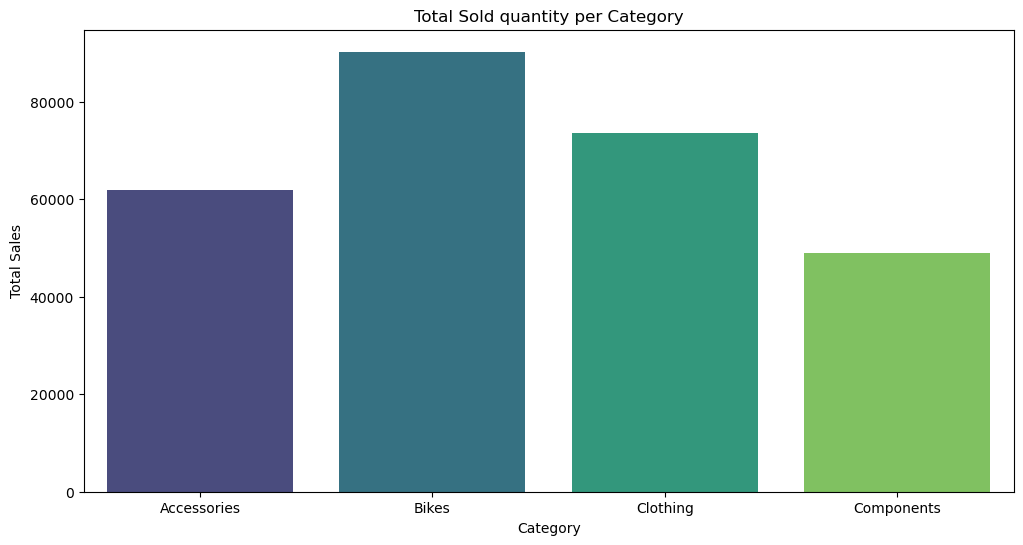

In [228]:
categories = products_sales.groupby(['CategoryName']).agg({'OrderQty': 'sum'}).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='CategoryName', y='OrderQty', data=categories, palette='viridis')
plt.title('Total Sold quantity per Category')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.show()

## Online vs Offline 

Even though most sales happen online, we still sell a lot in stores. We get many online orders for small amounts, but in stores, we sell large quantities consistently. We can also see that the total revenue from offline sales is around 4 times higher than for online sales and the average mean for offline purchases in offline sales is around 3 times higher. Median for online sales is more than 10 times higher than for offline sales.



In [229]:
on_off_sales = products_sales.groupby('OnlineOrderFlag').agg({'LineTotal': ['sum', 'mean','median'], 'OrderQty':['sum']}).reset_index()
print(on_off_sales)

  OnlineOrderFlag     LineTotal                       OrderQty
                            sum         mean   median      sum
0         Offline  8.048770e+07  1321.224974  461.694   214516
1          Online  2.935868e+07   486.086911   29.990    60398


Let's investigate why the difference in Total Revenue is so large between online and offline channels even though most of our orders are placed online. 
On average we sell 2.2 items per order online and 56.4 items offline. Why is there so large difference?

In [275]:
on_sales = products_sales[products_sales['OnlineOrderFlag']=='Online']
off_sales = products_sales[products_sales['OnlineOrderFlag']=='Offline']

on_mean_qty = on_sales.groupby('SalesOrderID')['OrderQty'].sum()
off_mean_qty = off_sales.groupby('SalesOrderID')['OrderQty'].sum()

on_mean_order_value = on_sales.groupby('SalesOrderID')['LineTotal'].sum().median()
off_mean_order_value = off_sales.groupby('SalesOrderID')['LineTotal'].sum().median()

print('Average Order quantity online:')
print(on_mean_qty.mean().round(2))

print('Median Order quantity online:')
print(on_mean_qty.median())

print('Median Order Value online:')
print(on_mean_order_value)

print('Average Order quantity offline:')
print(off_mean_qty.mean().round(2))

print('Median Order quantity offline:')
print(off_mean_qty.median())

print('Median Order Value offline:')
print(off_mean_order_value)

Average Order quantity online:
2.18
Median Order quantity online:
2.0
Median Order Value online:
594.97
Average Order quantity offline:
56.36
Median Order quantity offline:
25.0
Median Order Value offline:
8257.084896


In [271]:
import scipy.stats as stats

online_products_per_order = on_sales.groupby('SalesOrderID')['OrderQty'].sum()
offline_products_per_order = off_sales.groupby('SalesOrderID')['OrderQty'].sum()

std_dev_online = np.std(online_products_per_order, ddof=1)
std_dev_offline = np.std(offline_products_per_order, ddof=1)

mean_online = np.mean(online_products_per_order)
mean_offline = np.mean(offline_products_per_order)

confidence_level = 0.95
alpha = 1 - confidence_level

ci_online = stats.t.interval(confidence_level, len(online_products_per_order) - 1,
                             loc=mean_online, scale=std_dev_online / np.sqrt(len(online_products_per_order)))

ci_offline = stats.t.interval(confidence_level, len(offline_products_per_order) - 1,
                              loc=mean_offline, scale=std_dev_offline / np.sqrt(len(offline_products_per_order)))

print(f"Konfidensintervall för Antal Produkter per Order (Online): {ci_online}")
print(f"Konfidensintervall för Antal Produkter per Order (Offline): {ci_offline}")

Konfidensintervall för Antal Produkter per Order (Online): (2.170299441039356, 2.197031265059924)
Konfidensintervall för Antal Produkter per Order (Offline): (53.98359917527957, 58.741571607694674)


Let's find betsellers online and offline. Bestseller Online is Water Bottle and Offline is Long-Sleve

In [64]:
on_sales = products_sales[products_sales['OnlineOrderFlag']=='Online']
off_sales = products_sales[products_sales['OnlineOrderFlag']=='Offline']

on_sales_products = on_sales.groupby(['ProductID', 'ProductName']).agg({'OrderQty':'sum'}).sort_values('OrderQty', ascending=False).reset_index()
off_sales_products = off_sales.groupby(['ProductID', 'ProductName']).agg({'OrderQty':'sum'}).sort_values('OrderQty', ascending=False).reset_index()
print('Online sales:')
print(on_sales_products.head())
print('\nOffline Sales:')
print(off_sales_products.head())

Online sales:
   ProductID            ProductName  OrderQty
0        870  Water Bottle - 30 oz.      4244
1        873    Patch Kit/8 Patches      3191
2        921     Mountain Tire Tube      3095
3        922         Road Tire Tube      2376
4        707  Sport-100 Helmet, Red      2230

Offline Sales:
   ProductID                 ProductName  OrderQty
0        715  Long-Sleeve Logo Jersey, L      6140
1        712                AWC Logo Cap      6121
2        711      Sport-100 Helmet, Blue      4618
3        708     Sport-100 Helmet, Black      4447
4        864             Classic Vest, S      4079


Let's find out which subcategories are most popular online and offline. 
* Online: Accessories such as Tires and Tubes are the most popular subcategory. 
* Offline: Bikes, such as Road bikes are the most popular

In [230]:
on_sales_subcategory = on_sales.groupby(['CategoryName', 'SubCategoryName']).agg({'OrderQty':['sum','mean','median']}).reset_index()
off_sales_subcategory = off_sales.groupby(['CategoryName', 'SubCategoryName']).agg({'OrderQty':['sum','mean','median']}).reset_index()

print('Online Sales:')
print(on_sales_subcategory.sort_values(('OrderQty','sum'), ascending=False).head())
print('\nOfflineSales')
print(off_sales_subcategory.sort_values(('OrderQty','sum'),ascending=False).head())

Online Sales:
  CategoryName    SubCategoryName OrderQty            
                                       sum mean median
7  Accessories    Tires and Tubes    17332  1.0    1.0
9        Bikes         Road Bikes     8068  1.0    1.0
2  Accessories  Bottles and Cages     7981  1.0    1.0
5  Accessories            Helmets     6440  1.0    1.0
8        Bikes     Mountain Bikes     4970  1.0    1.0

OfflineSales
   CategoryName SubCategoryName OrderQty                 
                                     sum      mean median
9         Bikes      Road Bikes    39128  3.038832    2.0
8         Bikes  Mountain Bikes    23351  3.118873    2.0
14     Clothing         Jerseys    19379  5.021767    4.0
3   Accessories         Helmets    13101  4.781387    4.0
10        Bikes   Touring Bikes    12584  2.819628    2.0


Let's look quantity wise how many products per order sales online. Now we see that people who buy our products online are individual customers and offline sales are made to Stores who then sale out products. That's why their orders are usually larger in amount and generate higher revenue. 

In [231]:
customer_type = pd.read_sql("""
                               SELECT A.CustomerID,
                                      A.PersonID, 
	                                  B.PersonType
                               FROM Sales.Customer AS A
                               LEFT JOIN Person.Person AS B
                                    ON A.PersonID = B.BusinessEntityID
                            """, con)
customer_type['PersonType'] = customer_type['PersonType'].map(dict_person_type)

off_sales_1 = off_sales.merge(customer_type, how='left', on='CustomerID')
on_sales_1 = on_sales.merge(customer_type, how='left', on='CustomerID')

off_sales_1_gr = off_sales_1.groupby('PersonType').agg({'OrderQty':'sum'}).reset_index()
on_sales_1_gr = on_sales_1.groupby('PersonType').agg({'OrderQty':'sum'}).reset_index()

print('Type of customers(Online Sales):')
print(on_sales_1_gr)
print('\nType of customers(Offline Sales):')
print(off_sales_1_gr)

Type of customers(Online Sales):
            PersonType  OrderQty
0  Individual customer     60398

Type of customers(Offline Sales):
      PersonType  OrderQty
0  Store Contact    214516


But is there any difference between products categories are the most popular online and offline?
* The most sold category online is Accessories while its the least sold category to stores. 
* Second most sold category sold online is Bikes and it's the most sold category offline
* There is no sale of components online but it's the third largest product category for offline sales
* Clothing is the third largest category sold online and in offline sales 

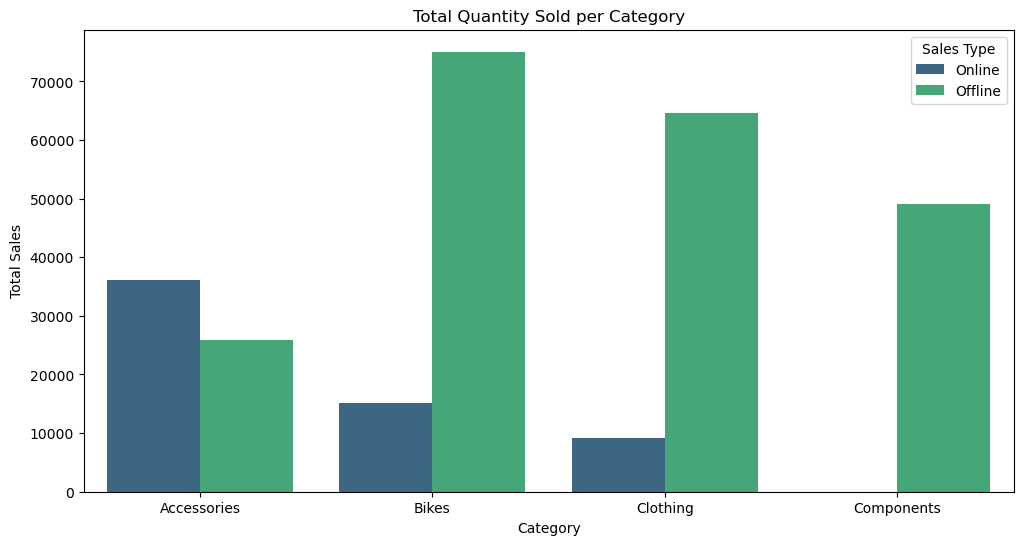

In [232]:
on_sales_category = on_sales.groupby(['CategoryName']).agg({'OrderQty':'sum'}).reset_index()
off_sales_category = off_sales.groupby(['CategoryName']).agg({'OrderQty':'sum'}).reset_index()


on_sales_category['SalesType'] = 'Online'
off_sales_category['SalesType'] = 'Offline'


combined_sales = pd.concat([on_sales_category, off_sales_category], ignore_index=True)


plt.figure(figsize=(12, 6))
sns.barplot(x='CategoryName', y='OrderQty', data=combined_sales, hue='SalesType', palette='viridis')

plt.title('Total Quantity Sold per Category')
plt.xlabel('Category')
plt.ylabel('Total Sales')

plt.legend(title='Sales Type')

plt.show()

So, induvidual customers buy accessories, bikes and clothing, 
While Stores buy bikes, Clothing, Components and accessories. 

Let's find out if there is some season trand in categories. 

## Insights from Online and Offline Sales Data

### Seasonal Patterns:

- Both online and offline sales exhibit seasonal patterns across different categories.
- Seasonal variations are observable in all three main categories: 'Accessories,' 'Bikes,' and 'Clothing.'
- For instance, in the 'Accessories' category, sales are relatively higher in Spring and Autumn for both online and offline channels.

### Online vs. Offline Comparison:

- The total order quantities for each season vary between online and offline channels.
- Some seasons have higher online sales, while others have higher offline sales.
- In some categories, online sales may outperform offline sales during specific seasons, while the opposite may be true for other categories.

### Category-wise Performance:

- Each category shows a unique distribution of sales across different seasons.
- For example, 'Bikes' have higher sales during Spring and Autumn compared to other seasons.
- 'Clothing' also experiences seasonal variations, with higher sales during Spring and Summer.

### Potential Strategies:

- Retailers can use these insights to tailor marketing and promotional strategies based on seasonal demand patterns.
- Timing promotions or new product launches to align with peak seasons can be beneficial.
- Understanding the difference in online and offline sales for each category allows for targeted efforts to enhance performance in specific channels.


   CategoryName OnlineOrderFlag  Season  OrderQty
0   Accessories         Offline  Autumn      5859
1   Accessories         Offline  Spring      8556
2   Accessories         Offline  Summer      8498
3   Accessories         Offline  Winter      2927
4   Accessories          Online  Autumn      8872
5   Accessories          Online  Spring     10317
6   Accessories          Online  Summer      7892
7   Accessories          Online  Winter      9011
8         Bikes         Offline  Autumn     17830
9         Bikes         Offline  Spring     21332
10        Bikes         Offline  Summer     20244
11        Bikes         Offline  Winter     15657
12        Bikes          Online  Autumn      3662
13        Bikes          Online  Spring      4910
14        Bikes          Online  Summer      2787
15        Bikes          Online  Winter      3846
16     Clothing         Offline  Autumn     14582
17     Clothing         Offline  Spring     19947
18     Clothing         Offline  Summer     21027


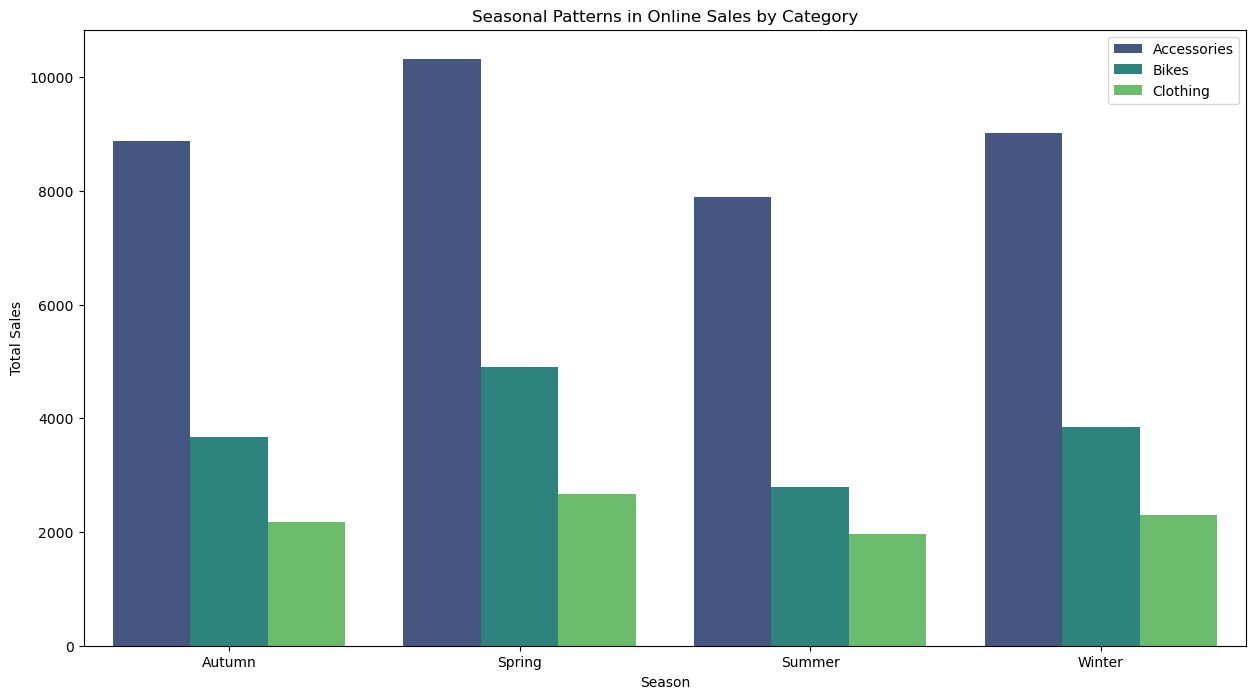

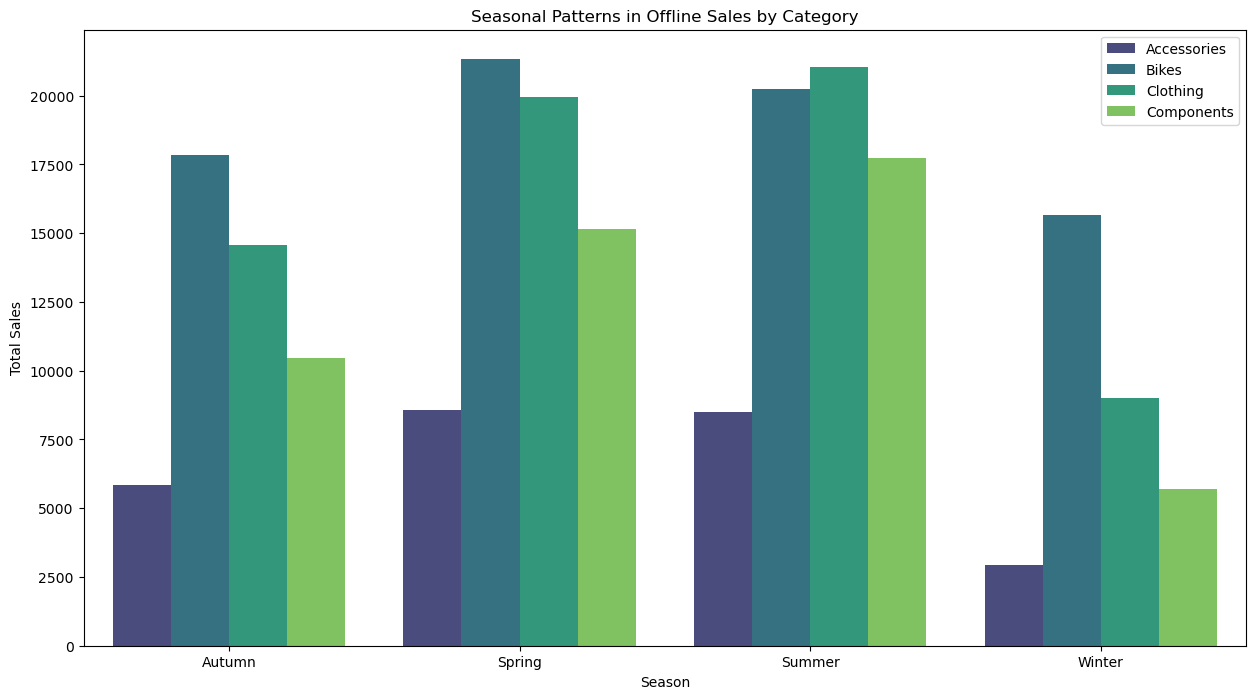

In [260]:
products_sales['OrderDate'] = pd.to_datetime(products_sales['OrderDate'])
products_sales['Month'] = products_sales['OrderDate'].dt.month


month_to_season = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Autumn',
    10: 'Autumn', 11: 'Autumn', 12: 'Winter'
}
products_sales['Season'] = products_sales['Month'].map(month_to_season)

grouped_data = products_sales.groupby(['CategoryName', 'OnlineOrderFlag', 'Season']).agg({'OrderQty': 'sum'}).reset_index()

online_data = grouped_data[grouped_data['OnlineOrderFlag'] == 'Online']
offline_data = grouped_data[grouped_data['OnlineOrderFlag'] == 'Offline']

print(grouped_data)

plt.figure(figsize=(15, 8))
sns.barplot(x='Season', y='OrderQty', hue='CategoryName', data=online_data, palette='viridis')
plt.title('Seasonal Patterns in Online Sales by Category')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


plt.figure(figsize=(15, 8))
sns.barplot(x='Season', y='OrderQty', hue='CategoryName', data=offline_data,palette='viridis')
plt.title('Seasonal Patterns in Offline Sales by Category')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

We assume that all the products that are manufactured by our company are ot purchased at any point of time. 
Let's analyze sales of products that were manufactured by our company. We assume that all the products that are manufactured by our company can't be purchased from vendors and that all the prices are in US dollars.

In [80]:
manufactured_sales = pd.read_sql("""
                                 WITH CTE_ProductionPrice_Cost AS (
                                      SELECT A.ProductID,
                                      C.[Name] AS ProductName,
                                      C.MakeFlag,
                                      C.ProductModelID,
                                      A.StartDate,
                                      A.EndDate,
                                      A.StandardCost
                                      FROM Production.ProductCostHistory AS A
                                      LEFT JOIN Production.ProductListPriceHistory AS B 
                                           ON A.ProductID = B.ProductID 
                                           AND A.StartDate = B.StartDate
                                      LEFT JOIN Production.Product AS C 
                                           ON A.ProductID = C.ProductID )

                                SELECT A.SalesOrderID,
                                       A.ProductID,
                                       D.ProductName,
                                       D.ProductModelID,
                                       B.OrderDate,
                                       A.OrderQty,
                                       A.UnitPrice - A.UnitPriceDiscount AS Price,
                                       D.StandardCost
                                FROM Sales.SalesOrderDetail AS A
                                LEFT JOIN Sales.SalesOrderHeader AS B 
                                     ON A.SalesOrderID = B.SalesOrderID
                                LEFT JOIN CTE_ProductionPrice_Cost AS D 
                                      ON A.ProductID = D.ProductID 
                                      AND B.OrderDate BETWEEN D.StartDate AND D.EndDate
                                WHERE D.MakeFlag = 1;
                                """,con)

manufactured_sales['Price'] = manufactured_sales['Price'].round(2)
manufactured_sales['StandardCost'] = manufactured_sales['StandardCost'].round(2)
print(manufactured_sales.head())

   SalesOrderID  ProductID              ProductName  ProductModelID  \
0         43659        776   Mountain-100 Black, 42              19   
1         43659        777   Mountain-100 Black, 44              19   
2         43659        778   Mountain-100 Black, 48              19   
3         43659        771  Mountain-100 Silver, 38              19   
4         43659        772  Mountain-100 Silver, 42              19   

   OrderDate  OrderQty    Price  StandardCost  
0 2011-05-31         1  2024.99       1898.09  
1 2011-05-31         3  2024.99       1898.09  
2 2011-05-31         1  2024.99       1898.09  
3 2011-05-31         1  2039.99       1912.15  
4 2011-05-31         1  2039.99       1912.15  


In [197]:
manufactured_sales['ProfitMargin'] = (manufactured_sales['Price'] - manufactured_sales['StandardCost'])/manufactured_sales['Price']
manufactured_sales.head()

,SalesOrderID,ProductID,ProductName,ProductModelID,OrderDate,OrderQty,Price,StandardCost,TotalMargin,ProfitMargin
0,43659,776,"Mountain-100 Black, 42",19,2011-05-31,1,2024.99,1898.09,126.90,0.062667
1,43659,777,"Mountain-100 Black, 44",19,2011-05-31,3,2024.99,1898.09,380.70,0.062667
2,43659,778,"Mountain-100 Black, 48",19,2011-05-31,1,2024.99,1898.09,126.90,0.062667
3,43659,771,"Mountain-100 Silver, 38",19,2011-05-31,1,2039.99,1912.15,127.84,0.062667
4,43659,772,"Mountain-100 Silver, 42",19,2011-05-31,1,2039.99,1912.15,127.84,0.062667


In [200]:
manuf_sales_grouped = manufactured_sales.groupby(['ProductID','ProductName','ProductModelID']).agg({'OrderQty':'sum','StandardCost':'mean', 'Price':'mean', 'ProfitMargin':'mean'}).reset_index().sort_values('ProfitMargin', ascending=False)
manuf_sales_grouped.head()

,ProductID,ProductName,ProductModelID,OrderQty,StandardCost,Price,ProfitMargin
24,751,"Road-150 Red, 48",25,493,2171.29,3326.303447,0.321987
25,752,"Road-150 Red, 52",25,458,2171.29,3290.493386,0.311866
23,750,"Road-150 Red, 44",25,437,2171.29,3270.418408,0.306193
22,749,"Road-150 Red, 62",25,600,2171.29,3170.194383,0.277866
57,784,"Mountain-200 Black, 46",20,967,1105.81,1615.999061,0.270178


In [201]:
manuf_sales_grouped.sort_values('ProfitMargin').head()

,ProductID,ProductName,ProductModelID,OrderQty,StandardCost,Price,ProfitMargin
35,762,"Road-650 Red, 44",30,2244,455.844912,459.013363,-0.065589
27,754,"Road-450 Red, 58",28,582,884.710000,874.531770,-0.011649
31,758,"Road-450 Red, 52",28,710,884.710000,874.790000,-0.011340
28,755,"Road-450 Red, 60",28,350,884.710000,874.790000,-0.011340
30,757,"Road-450 Red, 48",28,156,884.710000,874.790000,-0.011340


Price for products above should be increased. 

The best margin we get from Road-150 Red 48
The worst margine (-76458 Dollars) from Road 650 RED 44. 

In [213]:
discount=pd.read_sql("""SELECT A.SalesOrderID,
                               B.[Name] AS DiscountReason
                        FROM Sales.SalesOrderHeaderSalesReason AS A
                        LEFT JOIN Sales.SalesReason AS B
                        ON A.SalesReasonID = B.SalesReasonID
                        """,con)

merged_df = pd.merge(manufactured_sales, discount, on='SalesOrderID', how='left')

merged_df['DiscountReason'].fillna('Full Price', inplace=True)

print(merged_df[merged_df['ProductID']==751].groupby('DiscountReason').agg({'ProfitMargin':'mean','OrderQty':'sum'}))

                ProfitMargin  OrderQty
DiscountReason                        
Full Price         -0.011332       156
Manufacturer        0.393201       337
Quality             0.393201       337


In [85]:
merged_df.value_counts('DiscountReason')

DiscountReason
Full Price      23948
Manufacturer     1551
Quality          1551
On Promotion      993
Review            521
dtype: int64

Manufacturer:

This discount reason may indicate that a discount is applied due to a manufacturer-related promotion, special deal, or arrangement.
Quality:

This discount reason may suggest that a discount is applied based on the perceived quality of the product. It could be related to quality issues or as an incentive to promote products with high quality.
On Promotion:

This discount reason likely indicates that the discount is part of a promotional campaign. It could be a temporary reduction in prices to stimulate sales during a specific period.
Review:

The exact meaning of "Review" is not clear from the information provided. It might be a discount reason related to product reviews, customer feedback, or some form of evaluation.

In [178]:
df_models = pd.read_sql("""SELECT ProductModelID,
                                  [NAME] AS ModelName
                           FROM Production.ProductModel""",con)


In [206]:
df_merged_model = manuf_sales_grouped.merge(df_models, on='ProductModelID', how='left')

In [234]:
df_merged_model_gr = df_merged_model.groupby(['ProductModelID','ModelName']).agg({'OrderQty':'sum','StandardCost':'mean', 'Price':'mean', 'ProfitMargin':'mean'}).reset_index().sort_values('ProfitMargin', ascending=False)
df_merged_model_gr.sort_values('OrderQty', ascending=False)

,ProductModelID,ModelName,OrderQty,StandardCost,Price,ProfitMargin
14,30,Road-650,17564,457.745494,493.933117,0.037674
8,20,Mountain-200,6975,1111.835000,1555.367031,0.239846
11,26,Road-250,5685,1394.971250,1786.942669,0.168792
2,9,LL Road Frame,5289,179.207415,190.021201,0.056107
7,19,Mountain-100,4951,1905.120000,2233.260943,0.045135
13,29,Road-550-W,3425,605.650000,714.307714,0.105962
9,21,Mountain-300,2947,598.440000,647.843913,0.076252
0,5,HL Mountain Frame,2683,666.960275,763.570701,0.126218
10,25,Road-150,2652,2171.290000,3218.657693,0.291563
12,28,Road-450,2144,884.710000,874.738354,-0.011402


Let's build CI for 2 most profitable models: Road 150 and Mountain-100

In [262]:
df_for_ci= manufactured_sales.merge(df_models, on='ProductModelID', how='left')
df_for_ci

,SalesOrderID,ProductID,ProductName,ProductModelID,OrderDate,OrderQty,Price,StandardCost,TotalMargin,ProfitMargin,ModelName
0,43659,776,"Mountain-100 Black, 42",19,2011-05-31,1,2024.99,1898.09,126.90,0.062667,Mountain-100
1,43659,777,"Mountain-100 Black, 44",19,2011-05-31,3,2024.99,1898.09,380.70,0.062667,Mountain-100
2,43659,778,"Mountain-100 Black, 48",19,2011-05-31,1,2024.99,1898.09,126.90,0.062667,Mountain-100
3,43659,771,"Mountain-100 Silver, 38",19,2011-05-31,1,2039.99,1912.15,127.84,0.062667,Mountain-100
4,43659,772,"Mountain-100 Silver, 42",19,2011-05-31,1,2039.99,1912.15,127.84,0.062667,Mountain-100
...,...,...,...,...,...,...,...,...,...,...,...
27008,51076,763,"Road-650 Red, 48",30,2013-05-29,1,782.99,486.71,296.28,0.378396,Road-650
27009,51077,780,"Mountain-200 Silver, 42",20,2013-05-29,1,2071.42,1117.86,953.56,0.460341,Mountain-200
27010,51078,782,"Mountain-200 Black, 38",20,2013-05-29,1,2049.10,1105.81,943.29,0.460344,Mountain-200
27011,51079,783,"Mountain-200 Black, 42",20,2013-05-29,1,2049.10,1105.81,943.29,0.460344,Mountain-200


In [267]:
profit_margin_data_road_150 = df_for_ci[df_for_ci['ModelName'] == 'Road-150']['ProfitMargin']
profit_margin_data_mountain_200 = df_for_ci[df_for_ci['ModelName'] == 'Mountain-200']['ProfitMargin']


mean_road_150 = np.mean(profit_margin_data_road_150)
std_dev_road_150 = np.std(profit_margin_data_road_150)

mean_mountain_200 = np.mean(profit_margin_data_mountain_200)
std_dev_mountain_200 = np.std(profit_margin_data_mountain_200)


confidence_level = 0.95


critical_value_road_150 = stats.norm.ppf(1 - (1 - confidence_level) / 2)
critical_value_mountain_200 = stats.norm.ppf(1 - (1 - confidence_level) / 2)


se_road_150 = std_dev_road_150 / np.sqrt(len(profit_margin_data_road_150))
se_mountain_200 = std_dev_mountain_200 / np.sqrt(len(profit_margin_data_mountain_200))


margin_of_error_road_150 = critical_value_road_150 * se_road_150
margin_of_error_mountain_200 = critical_value_mountain_200 * se_mountain_200


ci_road_150 = (mean_road_150 - margin_of_error_road_150, mean_road_150 + margin_of_error_road_150)
ci_mountain_200 = (mean_mountain_200 - margin_of_error_mountain_200, mean_mountain_200 + margin_of_error_mountain_200)

print(f"Confidence Interval for Road-150 Profit Margin: {ci_road_150}")
print(f"Confidence Interval for Mountain-200 Profit Margin: {ci_mountain_200}")

Confidence Interval for Road-150 Profit Margin: (0.28128689384872285, 0.2964613598253395)
Confidence Interval for Mountain-200 Profit Margin: (0.2324923948280028, 0.2454993033218608)


In [276]:
con.close()